## Plot feature distribution over time

In [3]:
import pandas as pd

races_df = pd.read_csv("../data/races.csv")

races_df

,Unnamed: 0,date_time,race_id,n_runners,number,current_odds,current_place_odds,place,relevance,Current_Odds_Feature
0,0,2019-01-01 13:15:00,2764219,7,2,5.50,2.12,3,1,5.50
1,1,2019-01-01 13:15:00,2764219,7,3,9.00,3.00,7,0,9.00
2,2,2019-01-01 13:15:00,2764219,7,4,1.83,1.20,2,1,1.83
3,3,2019-01-01 13:15:00,2764219,7,5,13.00,4.00,1,3,13.00
4,4,2019-01-01 13:15:00,2764219,7,6,10.00,3.25,6,0,10.00
...,...,...,...,...,...,...,...,...,...,...
6132,6132,2019-01-31 21:00:00,2786031,9,5,8.00,2.40,1,3,8.00
6133,6133,2019-01-31 21:00:00,2786031,9,6,13.00,3.40,3,2,13.00
6134,6134,2019-01-31 21:00:00,2786031,9,7,13.00,3.40,2,2,13.00
6135,6135,2019-01-31 21:00:00,2786031,9,8,5.00,1.80,6,1,5.00


                 std
year-month          
2019-09     0.158831
2019-10     0.149630
2019-11     0.140038
2019-12     0.130644
2020-01     0.127181
2020-02     0.137958
2020-03     0.154256
2020-06     0.153273
2020-07     0.150824
2020-08     0.138454
2020-09     0.132835
2020-10     0.141204
2020-11     0.145772
2020-12     0.143558
2021-01     0.135016
2021-02     0.147083
2021-03     0.144800
2021-04     0.144538
2021-05     0.138858
2021-06     0.140738
2021-07     0.141347
2021-08     0.132349
2021-09     0.132343
2021-10     0.142927
2021-11     0.149227
2021-12     0.151576
2022-01     0.138695
2022-02     0.146474
2022-03     0.148196
2022-04     0.151855
2022-05     0.142887
2022-06     0.142789
2022-07     0.142790
2022-08     0.132983
2022-09     0.137346


<AxesSubplot:xlabel='Horse_Win_Rate', ylabel='year-month'>

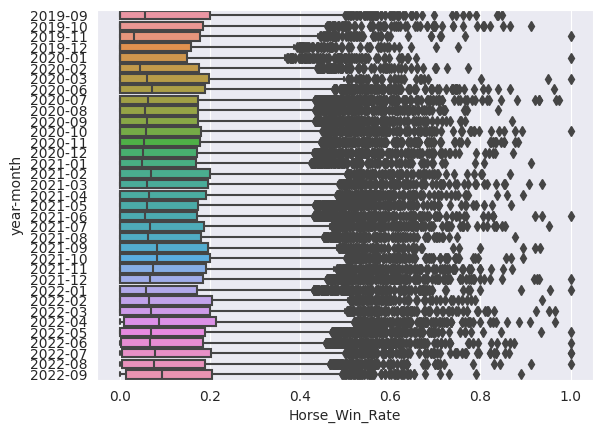

In [9]:
import seaborn as sns

races_df["year-month"] = races_df["date_time"].astype(str).str[:7]
races_df["date"] = pd.to_datetime(races_df["date_time"], format='%Y-%m-%d')
races_df["dayofweek"] = races_df["date"].dt.dayofweek.astype(str)
races_df["hour"] = races_df["date"].dt.hour.astype(str)
races_df["month"] = races_df["date"].dt.month.astype(str)

print(races_df.groupby(["year-month"]).agg(std=("Horse_Win_Rate", "std")))

sns.boxplot(data=races_df, x="Horse_Win_Rate", y="year-month")

# Covariate Shift Detection

## 1.) Between a month and its predecessor

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

races_df = pd.read_csv("../data/races.csv")
races_df["year-month"] = races_df["date_time"].astype(str).str[:7]

month_df = races_df[races_df["year-month"].isin(["2022-09", "2022-08"])]
month_df["label"] = np.where(month_df["year-month"] == "2022-09", 1, 0)

month_df = month_df.fillna(value=-1)

month_df = month_df.drop(["date_time", "race_id", "horse_id", "year-month", "Month_Sin", "Month_Cos", "Unnamed: 0"], axis=1)

print(month_df)

features = [column for column in month_df.columns if column not in ["label"]]
shift_X = month_df.loc[:, features]
scaler = StandardScaler().fit(shift_X)
shift_X = scaler.transform(shift_X)

shift_y = month_df.loc[:, "label"]

X_train, X_test, y_train, y_test = train_test_split(shift_X, shift_y, test_size=0.33, random_state=42, stratify=shift_y)

log_regression_classifier = LogisticRegression(random_state=0).fit(X_train, y_train)
print(f"Classifier score:{log_regression_classifier.score(X_test, y_test)}")

coef_data = {
    "feature name": list([column for column in features]),
    "coeff": list(list(log_regression_classifier.coef_)[0]),
}

coeff_df = pd.DataFrame.from_dict(coef_data)
coeff_df.sort_values(by=["coeff"])

       n_runners  current_odds  current_place_odds  place  has_won  relevance  \
80410         11          4.20                1.64      6        0         27   
80411         11         67.00               14.20      9        0         25   
80412         11         15.00                3.80      3        0         30   
80413         11         41.00                9.00     11        0         17   
80414         11         12.00                3.20      4        0         29   
...          ...           ...                 ...    ...      ...        ...   
92525         10          3.75                1.55      4        0         26   
92526         10         11.00                3.00      9        0         22   
92527         10         12.00                3.20      5        0         25   
92528         10         10.00                2.80      1        1         30   
92529         10         17.00                4.20      3        0         29   

       Current_Odds_Feature

/tmp/ipykernel_8287/2015652303.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_df["label"] = np.where(month_df["year-month"] == "2022-09", 1, 0)


,feature name,coeff
12,Draw_Bias,-0.377124
10,Age,-0.294436
1,current_odds,-0.280174
6,Current_Odds_Feature,-0.280174
11,Current_Rating,-0.240611
18,Hour_Cos,-0.177859
8,Current_Race_Class,-0.164490
14,Current_Race_Track,-0.159514
48,Average_Place_Surface,-0.119077
45,Jockey_Weight,-0.095458
